In [ ]:


import numpy as np
import pandas as pd 



import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv('../input/crop-recommendation-dataset/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


<AxesSubplot:xlabel='ph', ylabel='Density'>

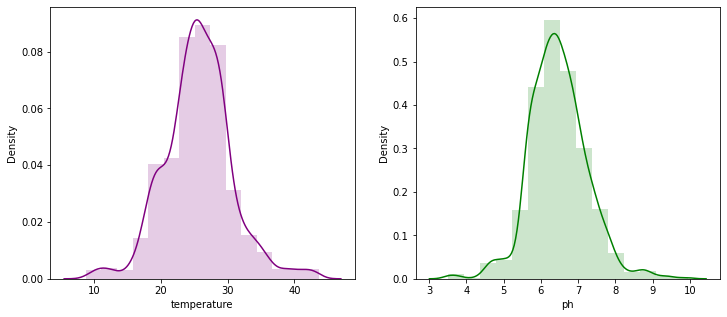

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# sns.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

#### During rainy season, average rainfall is high (average 120 mm) and temperature is mildly chill (less than 30'C).

#### Rain affects soil moisture which affects ph of the soil. Here are the crops which are likely to be planted during this season. 

- <b> Rice needs heavy rainfall (>200 mm) and a humidity above 80%. No wonder major rice production in India comes from East Coasts which has average of 220 mm rainfall every year!
- <b> Coconut is a tropical crop and needs high humidity therefore explaining massive exports from coastal areas around the country.

In [ ]:
sns.jointplot(x="rainfall",y="humidity",data=df[(df['temperature']<30) & (df['rainfall']>120)],hue="label")

In [ ]:
sns.jointplot(x="K",y="N",data=df[(df['N']>40)&(df['K']>40)],hue="label")

In [ ]:
sns.jointplot(x="K",y="humidity",data=df,hue='label',size=8,s=30,alpha=0.7)

In [ ]:
sns.boxplot(y='label',x='ph',data=df)

In [ ]:
sns.boxplot(y='label',x='P',data=df[df['rainfall']>150])

In [ ]:
sns.lineplot(data = df[(df['humidity']<65)], x = "K", y = "rainfall",hue="label")

In [15]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph']]

In [ ]:
sns.heatmap(X.corr())

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9781818181818182

In [ ]:
#models knn
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

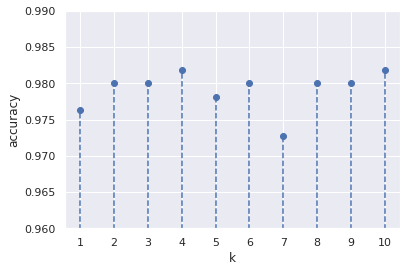

In [20]:
#Let's try different values of n_neighbors to fine tune and get better results
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

In [24]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9872727272727273

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

In [26]:
#Random forest

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

RF Accuracy on training set: 0.97
RF Accuracy on test set: 0.97


In [ ]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(clf, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier().fit(X_train, y_train)
print('Gradient Boosting accuracy : {}'.format(grad.score(X_test,y_test)))

Gradient Boosting accuracy : 0.9945454545454545
